In [0]:
%pip install wordcloud

Python interpreter will be restarted.
Collecting wordcloud
 Using cached wordcloud-1.8.1-cp37-cp37m-manylinux1_x86_64.whl (366 kB)
Collecting pillow
 Using cached Pillow-9.1.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
Requirement already satisfied: matplotlib in /databricks/python3/lib/python3.7/site-packages (from wordcloud) (3.1.3)
Requirement already satisfied: numpy>=1.6.1 in /databricks/python3/lib/python3.7/site-packages (from wordcloud) (1.18.1)
Requirement already satisfied: pyparsing!=2.0.4,!=2.1.2,!=2.1.6,>=2.0.1 in /databricks/python3/lib/python3.7/site-packages (from matplotlib->wordcloud) (2.4.6)
Requirement already satisfied: python-dateutil>=2.1 in /databricks/python3/lib/python3.7/site-packages (from matplotlib->wordcloud) (2.8.1)
Requirement already satisfied: kiwisolver>=1.0.1 in /databricks/python3/lib/python3.7/site-packages (from matplotlib->wordcloud) (1.1.0)
Requirement already satisfied: cycler>=0.10 in /databricks/python3/lib/python3.7/site-packages (from matplotlib->wordcloud) (0.10.0)
Requirement already satisfied: six>=1.5 in /databricks/python3/lib/python3.7/site-packages (from python-dateutil>=2.1->matplotlib->wordcloud) (1.14.0)
Requirement already satisfied: setuptools in /usr/local/lib/python3.7/dist-packages (from kiwisolver>=1.0.1->matplotlib->wordcloud) (45.2.0)
Installing collected packages: pillow, wordcloud
Successfully installed pillow-9.1.1 wordcloud-1.8.1
WARNING: You are using pip version 20.0.2; however, version 22.1.2 is available.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-06099b28-6a45-48fb-ba9e-dec2eadc92b3/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.

In [0]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
%pip install sparknlp

Python interpreter will be restarted.
Collecting sparknlp
 Downloading sparknlp-1.0.0-py3-none-any.whl (1.4 kB)
Collecting spark-nlp
 Downloading spark_nlp-3.4.4-py2.py3-none-any.whl (145 kB)
Requirement already satisfied: numpy in /databricks/python3/lib/python3.7/site-packages (from sparknlp) (1.18.1)
Installing collected packages: spark-nlp, sparknlp
Successfully installed spark-nlp-3.4.4 sparknlp-1.0.0
WARNING: You are using pip version 20.0.2; however, version 22.1.2 is available.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-06099b28-6a45-48fb-ba9e-dec2eadc92b3/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.

In [0]:
import sparknlp
from sparknlp.base import *


In [0]:

from pyspark.ml import Pipeline

# spark-nlp-1.3.0.jar is attached to the cluster. This library was downloaded from the
# spark-packages repository https://spark-packages.org/package/JohnSnowLabs/spark-nlp
from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *


# Spark NLP

In [0]:
# Create pre-processing stages

# Stage 1: DocumentAssembler as entry point
documentAssembler = DocumentAssembler() \
                    .setInputCol("value") \
                    .setOutputCol("document")
 
# Stage 2: Tokenizer
tokenizer = Tokenizer() \
              .setInputCols(["document"]) \
              .setOutputCol("token")
 
# Stage 3: Normalizer to lower text and to remove html tags, hyperlinks, twitter handles, 
# alphanumeric characters (integers, floats), timestamps in the format hh:mm (e.g. 10:30) and punctuation
cleanUpPatterns = [r"RT", "<[^>]*>", r"www\S+", r"http\S+", "@[^\s]+", "[\d-]", "\d*\.\d+", "\d*\:\d+", "[^\w\d\s]"]
normalizer = Normalizer() \
                .setInputCols("token") \
                .setOutputCol("normalized") \
                .setCleanupPatterns(cleanUpPatterns) \
                .setLowercase(True)
 
# Stage 4: Remove stopwords
stopwords = StopWordsCleaner()\
              .setInputCols("normalized")\
              .setOutputCol("cleanTokens")\
              .setCaseSensitive(False)
 
# Stage 5: Lemmatizer
lemma = LemmatizerModel.pretrained() \
              .setInputCols(["cleanTokens"]) \
              .setOutputCol("lemma")
 
# Stage 6: Stemmer stems tokens to bring it to root form
#.setInputCols(["cleanTokens"]).setOutputCol("stem") \
stemmer = Stemmer() \
            .setInputCols(["lemma"]) \
            .setInputCols(["cleanTokens"]) \
            .setOutputCol("stem")
 
# Stage 7: Finisher to convert custom document structure to array of tokens
finisher = Finisher() \
            .setInputCols(["stem"]) \
            .setOutputCols(["token_features"]) \
            .setOutputAsArray(True) \
            .setCleanAnnotations(False)

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[ | ][OK!]

In [0]:
# Create pre-processing stages
 
# Stage 1: DocumentAssembler as entry point
documentAssembler = DocumentAssembler() \
                    .setInputCol("value") \
                    .setOutputCol("document")
 
# Stage 2: Normalizer to lower text and to remove html tags, hyperlinks, twitter handles, alphanumeric characters (integers, floats) and timestamps in the format hh:mm (e.g. 10:30) 
cleanUpPatterns = [r"RT", r"\n\n", "<[^>]*>", r"www\S+", r"http\S+", "@[^\s]+", "[\d-]", "\d*\.\d+", "\d*\:\d+"]
documentNormalizer = DocumentNormalizer() \
                      .setInputCols("document") \
                      .setOutputCol("normalizedDocument") \
                      .setAction("clean") \
                      .setPatterns(cleanUpPatterns) \
                      .setReplacement("") \
                      .setPolicy("pretty_all") \
                      .setLowercase(True)


In [0]:
DF = (
   spark.read \
      .format("delta") \
      .load("/tmp/delta-tweet-table") \
      .createOrReplaceTempView("tweet_data")
)

tweet_df = spark.sql("SELECT * FROM tweet_data")

## Normalized

In [0]:
# Check pre-processing pipeline
cleanup_pipeline = Pipeline(stages=[documentAssembler, documentNormalizer])
empty_df = spark.createDataFrame([['']]).toDF("value")
prep_pipeline_model = cleanup_pipeline.fit(empty_df)
 
result = prep_pipeline_model.transform(tweet_df)
result.select('normalizedDocument.result').show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------+
result |
+-------------------------------------------------------------------------------------------------------------------------------+
["seven employees of a tennessee starbucks who were fired after starting unionization efforts have claimed victory af] |
[" no yeah tip for trans ppl choosing a name, go to starbucks or something and order as a name to test it out, works wonders"] |
[" my trans friend just had their gender affirming healthcare threatened by a district manager if they supported unioniza"] |
[" starbucks' antiunion tricks were no match for these courageous baristas.\n\ncongratulations to for another his"] |
[" the starbucks union crushes it in michigan\n\nthe union crushes starbucks in vote counts today\n\n in ann arbor ( stat"] |
[" breaking: starbucks workers in lawrence, kansas, just voted to unionize with rd and ousdah"] |
[" breaking: the poplar &amp; highland store in memphis, tn just won their union election . \n\nthis is the store where sta"] |
[" workers at the st &amp; pike store in seattle are filing for a union election. starbucks is turning their store into a h"] |
[" workers at the st &amp; pike store in seattle are filing for a union election. starbucks is turning their store into a h"] |
["if you work at starbucks and think you need a union, maybe look inward.] |
[" the growth of unions in in usa is amazing. congrats and solidarity from] |
[" well, selling my starbucks stock now. union will collapse the company eventually, watch all the upp] |
[" the starbucks union also crushes it in kansas today, with the workers at a starbucks in lawrence voting to in favor"] |
["question is do i get starbucks or a gallon of gas since they cost the same now"] |
[" the starbucks union crushes it in michigan\n\nthe union crushes starbucks in vote counts today\n\n in ann arbor ( stat"] |
[" workers at the st &amp; pike store in seattle are filing for a union election. starbucks is turning their store into a h"] |
["why does starbucks have a code for the bathroom let me take a dump"] |
[" a trip to starbucks, airports, walmart and the rnc will teach you more about the human race than any anthropology class co"]|
[" hallelujah to that. and im not just saying that because im sitting here with enough takeout food to l] |
[" starbucks' antiunion tricks were no match for these courageous baristas.\n\ncongratulations to for another his"] |
+-------------------------------------------------------------------------------------------------------------------------------+
only showing top 20 rows

## Token

In [0]:
# Check pre-processing pipeline
prep_pipeline = Pipeline(stages=[documentAssembler, tokenizer, normalizer, stopwords, lemma, stemmer, finisher])
 
empty_df = spark.createDataFrame([['']]).toDF("value")
prep_pipeline_model = prep_pipeline.fit(empty_df)
result = prep_pipeline_model.transform(tweet_df)


--------------------------------------------------------------------------- 
 TypeError Traceback (most recent call last)
 <command-2942148071314114> in <module> 
 3 
 4 empty_df3 = spark . createDataFrame ( [ [ '' ] ] ) . toDF ( "value" ) 
 ----> 5 prep_pipeline_model = prep_pipeline . fit ( empty_df3 ) 
 6 result = prep_pipeline_model . transform ( tweet_df ) 

 /databricks/spark/python/pyspark/ml/base.py in fit (self, dataset, params) 
 127 return self . copy ( params ) . _fit ( dataset ) 
 128 else : 
 --> 129 return self . _fit ( dataset ) 
 130 else : 
 131 raise ValueError("Params must be either a param map or a list/tuple of param maps, "

 /databricks/spark/python/pyspark/ml/pipeline.py in _fit (self, dataset) 
 95 if not ( isinstance ( stage , Estimator ) or isinstance ( stage , Transformer ) ) : 
 96 raise TypeError(
 ---> 97 "Cannot recognize a pipeline stage of type %s." % type(stage))
 98 indexOfLastEstimator = - 1 
 99 for i , stage in enumerate ( stages ) : 

 TypeError : Cannot recognize a pipeline stage of type <class 'set'>.

# WordCloud

## Negative Sentiment

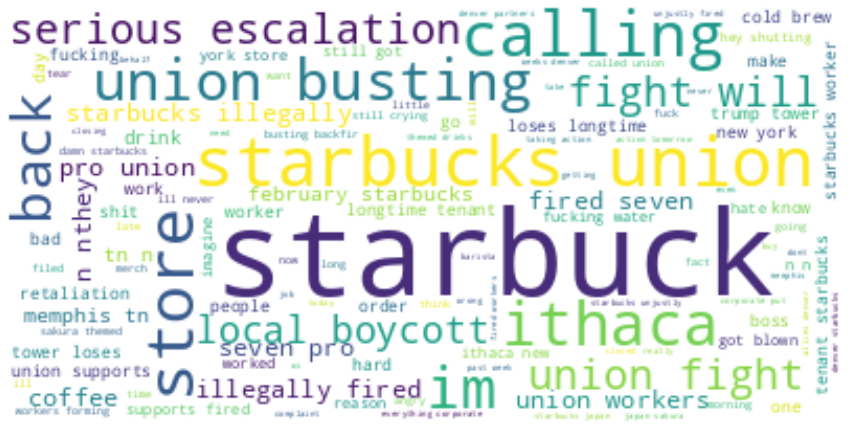

In [0]:
# Word cloud for negative tweets
neg = tweet_df.filter(tweet_df.sentiment == "Negative").toPandas()
text = " ".join(i for i in neg.processed_text)
text = text.lower()
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Positive Sentiment

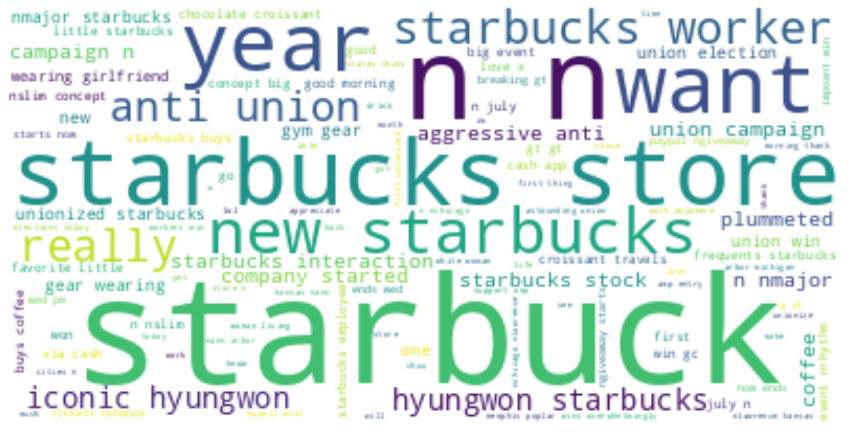

In [0]:
# Word cloud for negative tweets
pos = tweet_df.filter(tweet_df.sentiment == "Positive").toPandas()
text = " ".join(i for i in pos.processed_text)
text = text.lower()
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()